## **Notebook to make predictions with reprocessed Henson data and SPOT**

By Christina Schenk and Garrett Roell

Tested on biodesign_3.7 kernel on jprime

### SPOT predictions and evaluations
This notebook predicts fluxes for R. opacus cultures growing with phenol. The data was published in [Henson (2018)](https://www.sciencedirect.com/science/article/pii/S1096717618300910).

#### **Data Labels:**
                                                 
#### Henson:
* WT 0.5g/L Phenol 		(**WT-P**)
* PVHG6 0.5g/L  Phenol 	(**PVHG-P**)

### Method: 
<ol>
<li>Predict fluxes with SPOT</li>
<li>Compare predictions with 13CMFA: Scatter plots and flux maps</li>
<li>Load file with observed growth rates (Notebook E)</li>
<li>Compare growth rate predictions with growth rate observations</li>
</ol>


##### **Import python packages**

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
import scipy.stats
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg
import matplotlib.cm as cm

from edd_utils import login, export_study, export_metadata

from sklearn.metrics import r2_score

##### **Load data**

In [2]:
# # Study to Download
# study_slug = 'biodesign_henson2018_reprocessed'
# # EDD server
# edd_server = 'public-edd.jbei.org'
# user       = 'schenkch'

In [3]:
# session = login(edd_server=edd_server, user=user)

# df = export_study(session, study_slug, edd_server=edd_server)
# #df.head()

In [4]:
# define blank dictionary and fill with transcript measurements from different conditions and carbon sources
transcript_measurements = {}
# add glucose conditions to data set object
# transcript_measurements['glucose_cpm'] = pd.read_csv('../winston_data/october_19_2021/yoneda/yoneda_reprocess_CPM_melted.csv')
# transcript_measurements['glucose_fpkm'] = pd.read_csv('../winston_data/october_19_2021/yoneda/yoneda_reprocess_FPKM_melted.csv')
# transcript_measurements['glucose_mr'] = pd.read_csv('../winston_data/october_19_2021/yoneda/yoneda_reprocess_MR_melted.csv')
# transcript_measurements['glucose_tmm'] = pd.read_csv('../winston_data/october_19_2021/yoneda/yoneda_reprocess_TMM_melted.csv')
# add phenol conditions to data set object
transcript_measurements['phenol_cpm'] = pd.read_csv('../winston_data/october_19_2021/henson/henson_reprocess_CPM_melted.csv')
transcript_measurements['phenol_fpkm'] = pd.read_csv('../winston_data/october_19_2021/henson/henson_reprocess_FPKM_melted.csv')
transcript_measurements['phenol_mr'] = pd.read_csv('../winston_data/october_19_2021/henson/henson_reprocess_MR_melted.csv')
transcript_measurements['phenol_tmm'] = pd.read_csv('../winston_data/october_19_2021/henson/henson_reprocess_TMM_melted.csv')

##### **Filter transcriptomics data from all EDD data into different dataframes**

In [5]:
# df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
# df_Trans.head()

In [6]:
df_Trans = transcript_measurements['phenol_tmm'] #fpkm

##### **Load Genome Scale Model**

In [7]:
file_name =  '../GSMs/Ropacus_annotated_curated.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import EFLUX2 and SPOT Code**

In [8]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import SPOT

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [9]:
#Function to construct df from EFLUX2 functions: Needs to be modified for multiple time points!!!!!
def construct_trans_df(transdata, linename):
    transdataWTPR1 = transdata[transdata['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **SPOT Predictions**

In [10]:
#Function for EFLUX2 and SPOT Predictions:
def spot_pred(model, transcriptdf, linename, substrate, sub_uptake_rate=100):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            medium["EX_glc__D_e"] = 0
            medium['EX_guaiacol_e'] = 0
            medium['EX_vanlt_e'] = 0
            medium['EX_tag'] = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').upper_bound = -sub_uptake_rate
            #model.reactions.get_by_id('EX_phenol_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0
            model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
            model.reactions.get_by_id('EX_guaiacol_e').upper_bound = 0
            model.reactions.get_by_id('EX_guaiacol_e').lower_bound = 0
            model.reactions.get_by_id('EX_vanlt_e').upper_bound = 0
            model.reactions.get_by_id('EX_vanlt_e').lower_bound = 0
            model.reactions.get_by_id('EX_tag').upper_bound = 0
            model.reactions.get_by_id('EX_tag').lower_bound = 0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            medium = {key:1000 for (key,value) in model.medium.items()}
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            model.reactions.get_by_id('Growth').upper_bound = 0
            model.reactions.get_by_id('Growth').lower_bound = 0
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0
            medium['EX_guaiacol_e'] = 0
            medium['EX_vanlt_e'] = 0
            medium['EX_tag'] = 0
            model.reactions.get_by_id('EX_glc__D_e').upper_bound = 0#-sub_uptake_rate
            #model.reactions.get_by_id('EX_glc__D_e').lower_bound = -sub_uptake_rate
            model.reactions.get_by_id('EX_phenol_e').upper_bound = 0
            model.reactions.get_by_id('EX_phenol_e').lower_bound = 0
            model.reactions.get_by_id('EX_guaiacol_e').upper_bound = 0
            model.reactions.get_by_id('EX_guaiacol_e').lower_bound = 0
            model.reactions.get_by_id('EX_vanlt_e').upper_bound = 0
            model.reactions.get_by_id('EX_vanlt_e').lower_bound = 0
            model.reactions.get_by_id('EX_tag').upper_bound = 0
            model.reactions.get_by_id('EX_tag').lower_bound = 0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        spotsol = SPOT(model, transcriptdf)
    return spotsol

In [11]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def spot_pred_for_three_reps(model, transcriptdf, linename1, linename2, linename3, substrate):
    #call prediction functions for individual spot predictions for all 3 replicates:
    transdata_R1 = construct_trans_df(transcriptdf, linename1)
    transdata_R2 = construct_trans_df(transcriptdf, linename2)
    transdata_R3 = construct_trans_df(transcriptdf, linename3)
 
    spotsol_R1 = spot_pred(model, transdata_R1, linename1, substrate)
    spotsol_R2 = spot_pred(model, transdata_R2, linename2, substrate)
    spotsol_R3 = spot_pred(model, transdata_R3, linename3, substrate)
    
    #spot calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    
    spotsol = pd.DataFrame(spotsol_all.mean(axis=1), columns=['fluxes'])
    spotsol_std = spotsol_all.std(axis=1)
    
    return spotsol, spotsol_std

In [12]:
spotsol, spotsol_std = spot_pred_for_three_reps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol')

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

##### **Save solution to data frame**

In [13]:
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['stds'])

In [14]:
spotsol.loc['Growth_Glucose']

fluxes    0.0
Name: Growth_Glucose, dtype: float64

In [15]:
spotsol.loc['Growth_Phenol']

fluxes   -3.806431e-12
Name: Growth_Phenol, dtype: float64

In [16]:
spotsol.loc['EX_tag']

fluxes    0.0
Name: EX_tag, dtype: float64

##### **Check External Metabolites solution**

In [17]:
exchange_list = []
for ind in spotsoldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)

In [18]:
spotsoldf.loc[exchange_list,:]
for i in exchange_list:
    if spotsoldf.loc[i,:].values>=0.0001:
        display(spotsoldf.loc[i,:])
    

fluxes    0.155557
Name: EX_h_e, dtype: float64

fluxes    0.001654
Name: EX_leu__L_e, dtype: float64

fluxes    0.004791
Name: EX_acac_e, dtype: float64

fluxes    0.003787
Name: EX_acald_e, dtype: float64

fluxes    0.071268
Name: EX_succ_e, dtype: float64

fluxes    0.121954
Name: EX_co2_e, dtype: float64

fluxes    0.00213
Name: EX_fum_e, dtype: float64

fluxes    0.000259
Name: EX_pdima_e, dtype: float64

fluxes    0.002316
Name: EX_val__L_e, dtype: float64

#### **Plot solutions: Comparison of SPOT predictions and 13c measurements**

##### **Add Phenol SPOT flux values to phenol fluxes dataframe**

In [19]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.stds[reaction_id]
    else:
        return solution.stds[reaction_id]

##### **Scale up solution to compare with 13C MFA measurements**

In [20]:
def scale_predictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'], dtype=np.float64)
    scalepred_fluxes = pd.DataFrame(index=predictions.index, columns= ['fluxes'], dtype=np.float64)
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
    else:   
        print('Unknown Substrate')
    for ind in stdpredictions.index:
        if abs(stdpredictions.loc[ind,'stds'])<1e-5:
            scalepred_stds.loc[ind,'stds'] = stdpredictions.loc[ind,'stds']
        else:
            scalepred_stds.loc[ind,'stds'] = (stdpredictions.loc[ind,'stds']/predictions.loc[ind,'fluxes'])*scalepred_fluxes.loc[ind, 'fluxes']
    return scalepred_fluxes, scalepred_stds

##### **Add predictions to 13c data frame**

In [21]:
def add_pred_fluxes_to_13c_df(observed_fluxes, predictions, stdpredictions, substrate, method, strain):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scale_predictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    for _, row in observed_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' ' + str(strain) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' ' + str(strain) + ' std Value'] = predicted_stds
    
    return observed_fluxes

##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [22]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
phenol_fluxes.dropna(subset = ["Forward Reactions"], inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 43 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000


In [23]:
obspred_fluxes = add_pred_fluxes_to_13c_df(phenol_fluxes, spotsoldf, spotsolstddf, 'phenol', 'SPOT', 'WT')

In [24]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT WT Value,SPOT WT std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,1.000000e+02,4.088584e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,4.348789e-08,1.843730e-11
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,7.323914e-08,5.062590e-11
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,7.477636e-08,5.262159e-11
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,1.442544e-07,5.204331e-11
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,2.930829e-07,1.168964e-10
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,2.930829e-07,-1.168964e-10
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,1.891157e+00,-2.974076e-08
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,2.999856e+00,5.195903e+00
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,-5.643789e+01,-2.883090e+01


### Plot SPOT vs 13C MFA

In [25]:
def mae_func(observed, predicted):
    """Mean Absolute Error.
    Multioutput case included."""

    if observed.ndim == 1:
        return np.mean(np.abs([y_o - y_p for y_o, y_p in zip(observed, predicted)]))
    else:
        return [
            np.mean(
                np.abs([y_o - y_p for y_o, y_p in zip(observed[:, i], predicted[:, i])])
            )
            for i in range(observed.shape[1])
        ]

In [26]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    pathway_list = sorted(list(set(obspred_fluxes['Pathway']))) #sorted list such that same colors with every run
    for pathway in pathway_list:
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' + str(strain) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    predicted1 = obspred_fluxes.loc[~obspred_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']), str(method)+' '+ str(strain) + ' ' + 'Value']
    observed1 =  obspred_fluxes.loc[~obspred_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']),'Flux']
    
    predicted2 = obspred_fluxes.loc[:, str(method)+' '+ str(strain) + ' ' + 'Value']
    observed2 =  obspred_fluxes.loc[:,'Flux']
    
    r2_scikit_1 = r2_score(observed1,predicted1)
    r2_scikit_2 = r2_score(observed2,predicted2)
    
    mae_score_1 = np.round(mae_func(observed1, predicted1),2)
    mae_score_2 = np.round(mae_func(observed2, predicted2),2)
    


    if substrate=='phenol':
        plt.title(r''+ r"$\bf{" + str(method) + "}$"  + ': ' + f"$R^2$={r2_scikit_2:.2F} ({r2_scikit_1:.2F}$^\star$), MAE={mae_score_2} ({mae_score_1}$^\star$)", fontsize=18) #star: without 'ATP -> ATP.ext', 'NADH <-> NADPH'
    else:
        plt.title(r''+ r"$\bf{" + str(method) + "}$" + ': '+ f"$R^2$={r2_scikit_2:.2F}, MAE={mae_score_2}", fontsize=18)#r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename+ '\n' + f"$R^2$={r2_scikit_2:.2F} (all reactions)", fontsize=18)#, MAE={mae_score}, MSE = {mse}, RMSE={rmse}
    plt.xlabel(r'Observations', fontsize=18)#13C MFA fluxes (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r'Predictions', fontsize=18)#+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend(fontsize=14)
    plt.show()

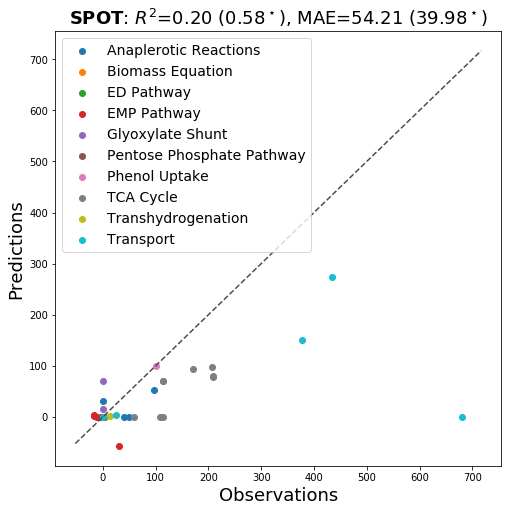

In [27]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='phenol', method='SPOT', strain='WT')

In [28]:
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method, strain):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    pathway_list = sorted(list(set(obspred_fluxes['Pathway'])))
    for pathway in pathway_list:                          
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' Value'])
        if str(method) + ' ' +  str(strain) + ' std Value' in pathway_df.columns:
            simulated_std_list = list(pathway_df[str(method) + ' ' +  str(strain) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        if pathway == 'Pentose Phosphate Pathway':
            pathway = 'PP Pathway'
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        if str(method) + ' ' +  str(strain) + ' std Value' in pathway_df.columns:
            ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)
        else: 
            ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list],
                    ecolor="gray", ls='none',
                    alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    predicted1 = obspred_fluxes.loc[~obspred_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']), str(method)+' '+ str(strain) + ' ' + 'Value']
    observed1 =  obspred_fluxes.loc[~obspred_fluxes['Reaction'].isin(['ATP -> ATP.ext', 'NADH <-> NADPH']),'Flux']
    
    predicted2 = obspred_fluxes.loc[:, str(method)+' '+ str(strain) + ' ' + 'Value']
    observed2 =  obspred_fluxes.loc[:,'Flux']
    
    r2_scikit_1 = r2_score(observed1,predicted1)
    r2_scikit_2 = r2_score(observed2,predicted2)
       
    mae_score_1 = np.round(mae_func(observed1, predicted1),2)
    mae_score_2 = np.round(mae_func(observed2, predicted2),2)
    


    if substrate=='phenol':
        plt.title(r''+ r"$\bf{" + str(method) + "}$"  + ': ' + f"$R^2$={r2_scikit_2:.2F} ({r2_scikit_1:.2F}$^\star$), MAE={mae_score_2} ({mae_score_1}$^\star$)", fontsize=18) #star: without 'ATP -> ATP.ext', 'NADH <-> NADPH'
    else:
        plt.title(r''+ r"$\bf{" + str(method) + "}$" + ': '+ f"$R^2$={r2_scikit_2:.2F}, MAE={mae_score_2}", fontsize=18)#r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes for ' +linename+ '\n' + f"$R^2$={r2_scikit_2:.2F} (all reactions)", fontsize=18)#, MAE={mae_score}, MSE = {mse}, RMSE={rmse}
    plt.ylabel(r'Predictions', fontsize=18)#+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend(fontsize=14)
    plt.savefig('Plots/TMM/Plot_13cwtihstd_'+str(method)+'_'+str(substrate)+'_'+str(strain)+'.svg')
    plt.savefig('Plots/TMM/Plot_13cwtihstd_'+str(method)+'_'+str(substrate)+'_'+str(strain)+'.png')
    plt.show()

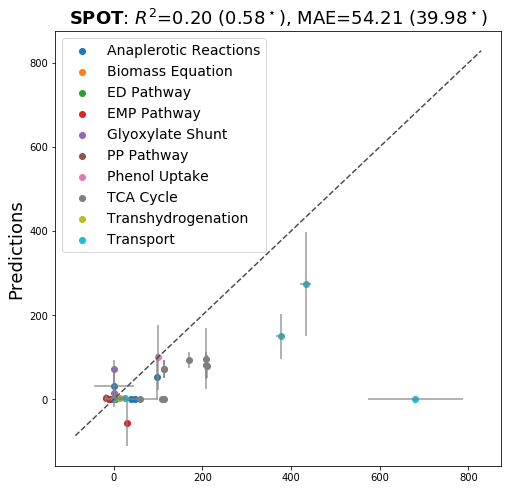

In [29]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='phenol', method='SPOT', strain='WT')

##### **PVHG**

In [30]:
spotsol_PVHG, spotsol_std_PVHG = spot_pred_for_three_reps(model, df_Trans, 'PVHG-P-R1', 'PVHG-P-R2','PVHG-P-R3', 'phenol')

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

{'EX_h2o_e': inf,
 'EX_h_e': inf,
 'EX_cl_e': inf,
 'EX_pi_e': inf,
 'EX_nh4_e': inf,
 'EX_fe3_e': inf,
 'EX_k_e': inf,
 'EX_ca2_e': inf,
 'EX_mg2_e': inf,
 'EX_mn2_e': inf,
 'EX_cobalt2_e': inf,
 'EX_zn2_e': inf,
 'EX_cu2_e': inf,
 'EX_o2_e': inf,
 'EX_fe2_e': inf,
 'EX_mobd_e': inf,
 'EX_so4_e': inf,
 'EX_phenol_e': inf}

##### **Save solution to data frame**

In [31]:
spotsoldf_PVHG = pd.DataFrame(spotsol_PVHG, columns=['fluxes'])
spotsolstddf_PVHG = pd.DataFrame(spotsol_std_PVHG, columns=['stds'])

##### **Add Phenol PVHG SPOT flux values to phenol fluxes dataframe**

In [32]:
obspred_fluxes = add_pred_fluxes_to_13c_df(obspred_fluxes, spotsoldf_PVHG, spotsolstddf_PVHG, 'phenol', 'SPOT', 'PVHG')

In [33]:
obspred_fluxes.to_csv('../13C_flux_data/obspredfluxes_Glucose_SPOT_TMM.csv', index=True, header= True)

#### Plot SPOT vs 13C MFA

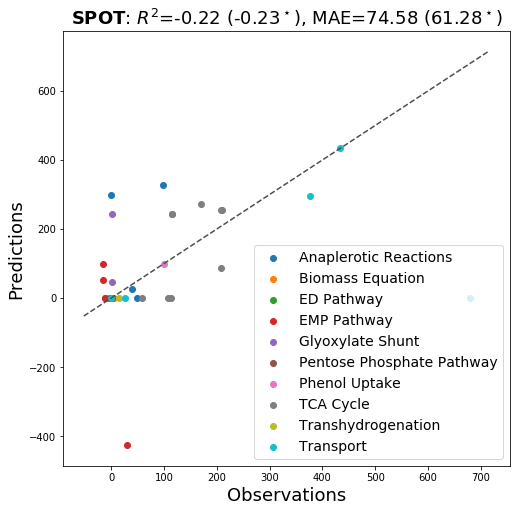

In [34]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='phenol', method='SPOT', strain='PVHG')

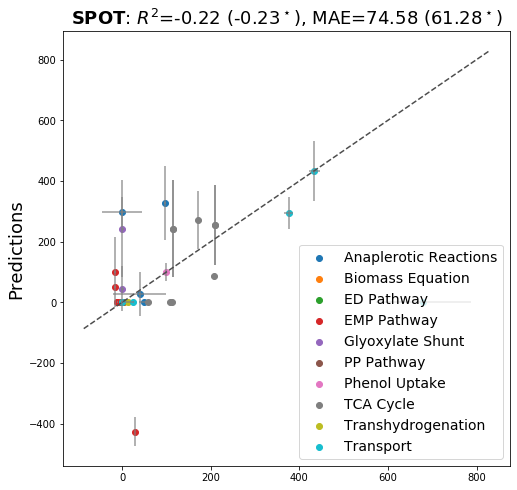

In [35]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='phenol', method='SPOT', strain='PVHG')

### Map phenol SPOT fluxes

In [36]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if not pd.isnull(row['Location on map']):
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}',textprops=dict(fontsize=22))
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)

    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    plt.savefig('Plots/TMM/Plot_fluxmap'+str(flux_column)+'s'+'TMM.svg')
    plt.savefig('Plots/TMM/Plot_fluxmap'+str(flux_column)+'s'+'TMM.png')
    plt.show()

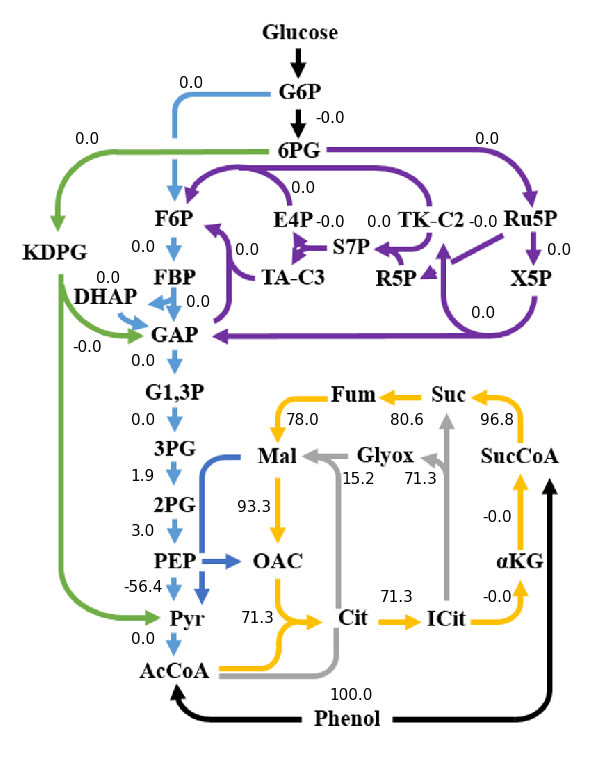

In [37]:
map_flux_results(obspred_fluxes, 'SPOT WT Value')

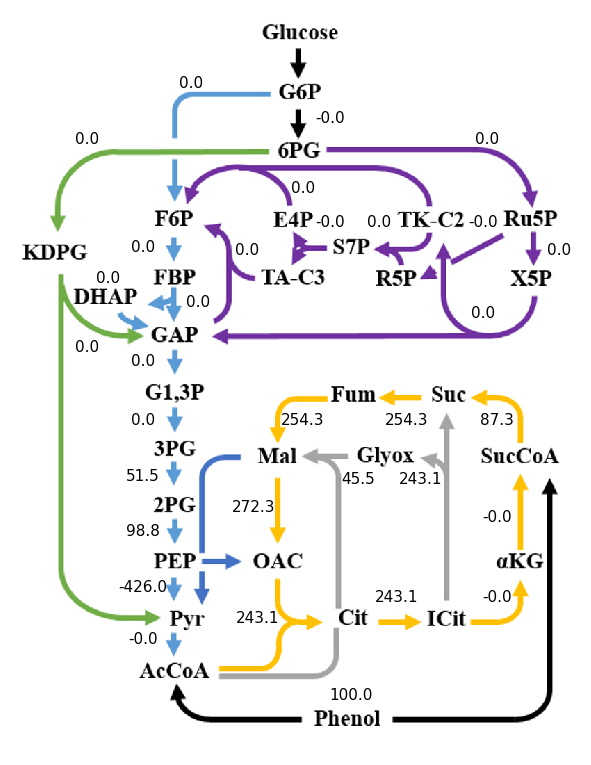

In [38]:
map_flux_results(obspred_fluxes, 'SPOT PVHG Value')

#### Load observed growth rates and plot phenol growth rates

In [39]:
consumption_and_growth_data = pd.read_csv('../consumption_and_growth_data/consumption_and_growth_data_new.csv', index_col=0)
consumption_and_growth_data

,growth rate,yield coefficient,substrate consumption rate,growth rate std dev,yield coefficient std dev,substrate consumption rate std dev
WT-P,0.065488,0.048868,1.352072,0.001345,0.004836,0.122279
PVHG-P,0.080331,0.040848,1.967485,0.002672,0.001757,0.021785
WT-LN-G,0.260195,0.072789,3.582471,0.004749,0.004117,0.141675


##### **For comparison of predicted and observed growth rates: scale predicted growth rate by multiplying with (observed substrate uptake / predicted substrate uptake)**

In [40]:
def scale_growth_to_sub(solgrowth, soluptake, sub_uptake_2comp):
    if soluptake<=1e-6:
        solgrowthnew = solgrowth
    else:
        factor = abs(sub_uptake_2comp/(-soluptake))
        solgrowthnew = solgrowth*factor
    return solgrowthnew

In [41]:
scaledgrowthratespot_wtp = scale_growth_to_sub(spotsoldf.loc['Growth_Phenol',:].values[0], spotsoldf.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['WT-P', 'substrate consumption rate'])
scaledgrowthratespot_pvhgp = scale_growth_to_sub(spotsoldf_PVHG.loc['Growth_Phenol',:].values[0], spotsoldf_PVHG.loc['EX_glc__D_e',:].values[0],consumption_and_growth_data.loc['PVHG-P',  'substrate consumption rate'])


##### **Load Glucose growth rates to compare in same plot** 

In [42]:
allgrowthratesglucose = pd.read_csv('../consumption_and_growth_data/allgrowthratesGlucoseSPOT_TMM.csv', index_col=0)
allgrowthratesglucose

,Growth_Glucose_SPOT
WT-LN-G,-5.075269e-09


In [43]:
allgrowthrates=pd.DataFrame(index=['WT-P', 'PVHG-P', 'WT-LN-G'], columns=['Growth_SPOT'], dtype=float)

In [44]:
allgrowthrates.at['WT-P','Growth_SPOT'] = scaledgrowthratespot_wtp
allgrowthrates.at['PVHG-P','Growth_SPOT'] = scaledgrowthratespot_pvhgp

In [45]:
allgrowthrates.at['WT-LN-G','Growth_SPOT'] = allgrowthratesglucose.loc['WT-LN-G','Growth_Glucose_SPOT']
allgrowthrates

,Growth_SPOT
WT-P,-3.806431e-12
PVHG-P,-6.436814e-12
WT-LN-G,-5.075269e-09


define function to calculate root mean squared error

In [46]:
def rmse_func(predicted, observed):
    return np.sqrt(((predicted - observed) ** 2).mean())

define function to calculate mean absolute error

In [47]:
def mae_func(predicted, observed):
    """Mean Absolute Error.
    Multioutput case included."""

    if observed.ndim == 1:
        return np.mean(np.abs([y_o - y_p for y_o, y_p in zip(observed, predicted)]))
    else:
        return [
            np.mean(
                np.abs([y_o - y_p for y_o, y_p in zip(observed[:, i], predicted[:, i])])
            )
            for i in range(observed.shape[1])
        ]

##### define function for mse

define function to compare growth rates in scatter plot

In [48]:
def scatter_plot_compare(observed, predicted, labels, method):
    fig, ax = plt.subplots(figsize=(8, 8))
    
#     lims = [
#                 np.min([observed, predicted]),  # min of both axes
#                 np.max([observed, predicted]),  # max of both axes
#             ]
    lims = [0, 0.4]
    ax.set_xlim(lims)
    
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        ax.annotate(str(labels[i]),(observed[i],predicted[i]), fontsize=14)
        
    #calculate statistical quantities:
    r2 = r2_score(observed,predicted)
    #mse = np.round(mse_func(predicted, observed),2)
    #rmse = np.round(rmse_func(predicted, observed),2)
    mae_score = np.round(mae_func(observed, predicted),2)

    
    plt.xlabel(r'Observations', fontsize=18)#ed growth rate [$mmol/gDW/hr$]',fontsize=14)
    plt.ylabel(r'Predictions', fontsize=18)#ed growth rate [$mmol/gDW/hr$]', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(r''+ r"$\bf{" + str(method) + "}$" +': '+ f"$R^2$={r2:.2F}, MAE={mae_score}", fontsize=18)#Growth rates: Observed vs. Predicted ('+strtitle+'), \n'
    #plt.title(r''+ r"$\bf{" + str(method) + "}$" +': '+ f"$R^2$={r2:.2F}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)#Growth rates: Observed vs. Predicted ('+strtitle+'), \n'
    plt.savefig('Plots/TMM/Plot_growthrates_SPOT.svg')
    plt.show()

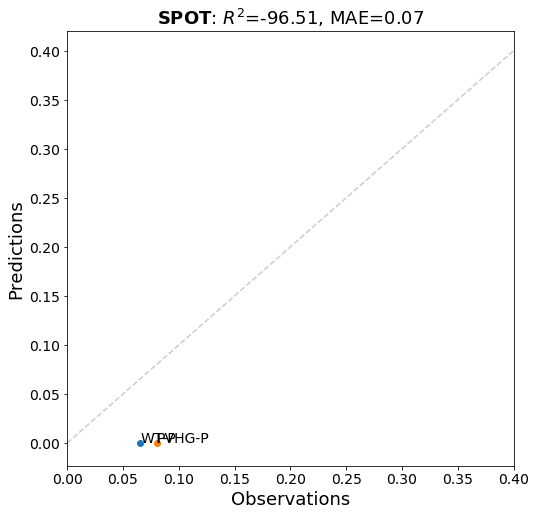

In [49]:
allindices=[str(row) for row in allgrowthrates.index]
scatter_plot_compare(consumption_and_growth_data.loc[['WT-P', 'PVHG-P'], 'growth rate'], allgrowthrates.loc[['WT-P', 'PVHG-P'],'Growth_SPOT'], allindices, 'SPOT')

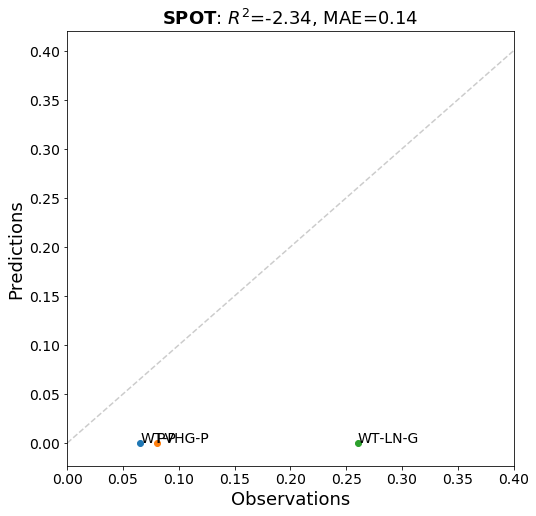

In [50]:
allindices=[str(row) for row in allgrowthrates.index]
scatter_plot_compare(consumption_and_growth_data.loc[allindices, 'growth rate'], allgrowthrates.loc[allindices,'Growth_SPOT'], allindices, 'SPOT')

In [51]:
allgrowthrates.to_csv('../consumption_and_growth_data/allgrowthratesSPOT_TMM.csv', index=True, header= True)